# Deep Convolutional Generative Adversarial Network

**Our goal is to train a model to generate images look like images in the training data.**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import itertools
from IPython import display
import imageio

In [ ]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

## Data preparation

In [4]:
CHANNELS = 1
BATCH_SIZE = 128
lr = 0.0002
NUM_EPOCHS = 20

MEAN_STD_NORMALIZATION = (0.5, 0.5, 0.5) if CHANNELS == 3 else (0.5,)
img_size = (64,64)
transform = transforms.Compose([
                transforms.Resize(img_size),
                transforms.ToTensor(),
                transforms.Normalize(mean=MEAN_STD_NORMALIZATION, std=MEAN_STD_NORMALIZATION)
            ])

dataset = datasets.MNIST(root='./data', 
                         train=True, 
                         download=True, 
                         transform=transform)

# dataset = datasets.CIFAR10(root='./data',
#                            train=True,
#                            download=True,
#                            transform=transform)

# dataroot = '/content/gdrive/My Drive/Colab Notebooks/img_align_celeba'
# dataset = datasets.ImageFolder(root=dataroot, transform=transform)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

0it [00:00, ?it/s]

9920512it [00:01, 8520245.88it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 130126.13it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2381806.38it/s]                           
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 49687.91it/s]            

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


In [ ]:
# results save folder
if not os.path.isdir('DCGAN_results'):
    os.mkdir('DCGAN_results')
if not os.path.isdir('DCGAN_results/Images_random'):
    os.mkdir('DCGAN_results/Images_random')
if not os.path.isdir('DCGAN_results/Images_fixed'):
    os.mkdir('DCGAN_results/Images_fixed')

## Building models

In [ ]:
# Initialize convolutional and convolutional-transpose layers from normal distribution
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

The generator takes a random vector of certain dimension as input and output image of dimension of 64x64. The goal of generator is to generate fake images to fool the discriminator.

In [7]:
class Generator(nn.Module):
    def __init__(self, noise_dim=100, d=128):
        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=noise_dim, 
                                           out_channels=d*8, 
                                           kernel_size=4, 
                                           stride=1, 
                                           padding=0,
                                           bias=False),
                        nn.BatchNorm2d(d*8),
                        nn.LeakyReLU()
        )
        self.block2 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=d*8, 
                                           out_channels=d*4, 
                                           kernel_size=4, 
                                           stride=2, 
                                           padding=1,
                                           bias=False),
                        nn.BatchNorm2d(d*4),
                        nn.LeakyReLU()
        ) 
        self.block3 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=d*4, 
                                           out_channels=d*2, 
                                           kernel_size=4, 
                                           stride=2, 
                                           padding=1,
                                           bias=False),
                        nn.BatchNorm2d(d*2),
                        nn.LeakyReLU()
        )
        self.block4 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=d*2, 
                                           out_channels=d, 
                                           kernel_size=4, 
                                           stride=2, 
                                           padding=1,
                                           bias=False),
                        nn.BatchNorm2d(d),
                        nn.LeakyReLU()
        )
        self.block5 = nn.Sequential(
                        nn.ConvTranspose2d(in_channels=d, 
                                           out_channels=CHANNELS, 
                                           kernel_size=4, 
                                           stride=2, 
                                           padding=1),
                        nn.Tanh()
        )

    # weight initialzation
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        # state size: batch_size x noise_dim x 1 x 1
        out = self.block1(x)
        # state size: batch_size x (d*8) x 4 x 4   = batch_size x 1024 x 4 x 4
        out = self.block2(out)
        # state size: batch_size x (d*4) x 8 x 8   = batch_size x 512 x 8 x 8
        out = self.block3(out)
        # state size: batch_size x (d*2) x 16 x 16 = batch_size x 256 x 16 x 16
        out = self.block4(out)
        # state size: batch_size x d x 32 x 32     = batch_size x 128 x 32 x 32
        out = self.block5(out)
        # state size: batch_size x CHANNELS x 64 x 64 
        return out
    
d = 128
NOISE_DIM = 100
G = Generator(NOISE_DIM, d).to(device)
G.weight_init(mean=0.0, std=0.02)
G

Generator(
  (block1): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block2): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block3): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (block4): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(neg

The discriminator take image of dimension 64x64 as input and output number between 0 and 1, which can be interpreted as the probability that the input image is real. The goal of discriminator is to correctly differentiate real images from fake images.

In [8]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.block1 = nn.Sequential(
                        nn.Conv2d(in_channels=CHANNELS, out_channels=d, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.LeakyReLU(),
                        nn.Dropout2d(p=0.3)
            )
        self.block2 = nn.Sequential(
                        nn.Conv2d(in_channels=d, out_channels=d*2, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(d*2),
                        nn.LeakyReLU(),
                        nn.Dropout2d(p=0.3)
            )
        self.block3 = nn.Sequential(
                        nn.Conv2d(in_channels=d*2, out_channels=d*4, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(d*4),
                        nn.LeakyReLU(),
                        nn.Dropout2d(p=0.3)
            )
        self.block4 = nn.Sequential(
                        nn.Conv2d(in_channels=d*4, out_channels=d*8, kernel_size=4, stride=2, padding=1, bias=False),
                        nn.BatchNorm2d(d*8),
                        nn.LeakyReLU(),
                        nn.Dropout2d(p=0.3)
            )
        self.block5 = nn.Sequential(
                        nn.Conv2d(in_channels=d*8, out_channels=1, kernel_size=4, stride=1, padding=0),
                        nn.Sigmoid()
            )

    # weight initialzation
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    def forward(self, x):
        # state size: batch_size x CHANNELS x 64 x 64
        out = self.block1(x)
        # state size: batch_size x d x 32 x 32     = batch_size x 128 x 32 x 32
        out = self.block2(out)
        # state size: batch_size x (d*2) x 16 x 16 = batch_size x 256 x 16 x 16
        out = self.block3(out)
        # state size: batch_size x (d*4) x 8 x 8   = batch_size x 512 x 8 x 8
        out = self.block4(out)
        # state size: batch_size x (d*8) x 4 x 4   = batch_size x 1024 x 4 x 4
        out = self.block5(out)
        # state size: batch_size x 1 x 1 x 1
        return out

d = 128      
D = Discriminator(d).to(device)
D.weight_init(mean=0.0, std=0.02)
D

Discriminator(
  (block1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Dropout2d(p=0.3)
  )
  (block2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.3)
  )
  (block3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout2d(p=0.3)
  )
  (block4): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Drop

## Define helper functions

In [ ]:
def imshow(images, rows, cols, figsize):
    #images.size(0) = rows x cols
    if images.size(1) == 1: 
        # CHANNELS == 1
        images = images.squeeze() # batch_size x rows x cols
    else:
        # CHANNELS == 3
        images = images.permute(0,2,3,1) # batch_size x rows x cols x channels
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    for i, j in itertools.product(range(rows), range(cols)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)

    for k in range(rows*cols):
        i = k // cols
        j = k - i*cols
        ax[i, j].cla()
        image = images[k] / 2 + 0.5
        ax[i, j].imshow(image.cpu().data.numpy())
    return fig, ax

In [ ]:
ROWS = 6
COLS= 6
with torch.no_grad():
    fixed_noise = torch.randn((ROWS * COLS, NOISE_DIM)).view(-1, NOISE_DIM, 1, 1).to(device)    # fixed noise
def show_result(num_epoch, show=False, save=False, path='result.png', fixedNoise=False):
    with torch.no_grad():
        noise = torch.randn((ROWS * COLS, NOISE_DIM)).view(-1, NOISE_DIM, 1, 1).to(device)
    G.eval()
    if fixedNoise:
        test_images = G(fixed_noise)
    else:
        test_images = G(noise)
    G.train()
    
    fig, ax = imshow(test_images, ROWS, COLS, (5,5))
    label = 'Epoch {}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha='center')
    
    if save: plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()

In [ ]:
def train_history(hist, show=False, save=False, path='train_hist.png'):
    x = range(len(hist['D_losses']))

    y1 = hist['D_losses']
    y2 = hist['G_losses']
    
    y3 = hist['D(real_data)']
    y4 = hist['D(fake_data1)']
    y5 = hist['D(fake_data2)']
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 8))
    ax[0].plot(x, y1, label='discriminator loss')
    ax[0].plot(x, y2, label='generator loss')
    ax[0].set_title("Loss of Generator and Discriminator")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend(loc='upper right')
    ax[0].grid(True)

    ax[1].plot(x, y3, label='D(real_data)')
    ax[1].plot(x, y4, label='D(fake_data1)')
    ax[1].plot(x, y5, label='D(fake_data2)')
    ax[1].set_title("Output probabilities of Discriminator")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("D(x) or D(G(z))")
    ax[1].legend(loc='upper right')
    ax[1].grid(True)
    
    plt.tight_layout(h_pad=1.5)
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()

## Models training

### Loss functions and optimizers

$$loss(x, y) = -[y\ log(x) + (1-y)\ log(1-x)]$$

In [ ]:
loss = nn.BCELoss()

In [ ]:
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

### Train the Discriminator

We train the discriminator by maximizing the loss $ log(D(x)) + log(1-D(G(z)))$, where $x$ is the real input image and $z$ is the input noise.


As practice, we devide the training into two parts. In the first part, we feed the discriminator a batch of real samples, and calculate $log(D(x))$, then calculate the gradients in a backward pass. In the second part, we feed the dicriminator a batch of fake samples, namely $D(G(z))$, then we calculate $log(1-D(G(z)))$ and accumulate the gradients with a backward pass. Finaly, we update the weights of discriminator using the optimizer of the discriminator.

We apply one-sided label smoothing technique in the training process when feeding real samples to the discriminator to prevent the discriminator from becoming too strong.

In [ ]:
def trainDiscriminator(optimizer, real_data, fake_data, label_smoothing):
    optimizer.zero_grad()
    
    D_real_output = D(real_data).squeeze()
    if label_smoothing:
        smoothing = torch.FloatTensor(1).uniform_(0, 0.3).item()
    else:
        smoothing = 0
    ones_target = torch.ones(mini_batch)*(1-smoothing) # one-sided label smoothing
    ones_target = ones_target.to(device)
    D_real_loss = loss(D_real_output, ones_target)
    D_real_loss.backward()

    D_fake_output = D(fake_data).squeeze()
    zeros_target = torch.zeros(mini_batch).to(device)
    D_fake_loss = loss(D_fake_output, zeros_target)
    D_fake_loss.backward()
    
    optimizer.step()
    
    D_train_loss = D_real_loss + D_fake_loss      
    return D_train_loss

### Train the Generator

We want to train the generator by minimizing the loss $log\left(1-D(G(z))\right)$. Practically,  we instead train the generator by maximizing $log(D(z))$.

In [ ]:
def trainGenerator(optimizer, fake_data):
    optimizer.zero_grad()
    
    D_fake_output = D(fake_data).squeeze()
    ones_target = torch.ones(mini_batch).to(device)
    G_train_loss = loss(D_fake_output, ones_target)
    G_train_loss.backward()
    optimizer.step()
    
    return G_train_loss

### Training Loop

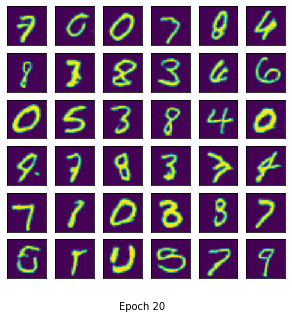

20/20 - time: 12.757875 minutes, discriminator_loss: 0.597603, generator_loss: 3.972515
 D(real): 0.787370, D(fake1): 0.055025, D(fake2): 0.074552
CPU times: user 2h 22min 9s, sys: 1h 52min 42s, total: 4h 14min 52s
Wall time: 4h 16min 16s


In [19]:
%%time
PATH = './models_param.pth'
train_hist = {'D_losses': [],
              'G_losses': [],
              'D(real_data)': [],
              'D(fake_data1)': [],
              'D(fake_data2)': [],
             }
start_time = time.time()
for epoch in range(NUM_EPOCHS):
    D.train()
    G.train()
    D_losses = []
    G_losses = []
    D_real = []
    D_fake1 = []
    D_fake2 = []
    epoch_start_time = time.time()
    for samples, _ in train_loader:
        mini_batch = samples.size(0)
        samples = samples.to(device)
        
        # train discriminator D
        noise = torch.randn((mini_batch, NOISE_DIM), requires_grad=True).view(-1, NOISE_DIM, 1, 1).to(device)
        fake_data = G(noise)
        label_smoothing = True # if epoch >= 10 else False
        D_train_loss = trainDiscriminator(D_optimizer, samples, fake_data, label_smoothing)
        D_losses.append(D_train_loss.item())
        with torch.no_grad():
            D_x = D(samples).view(-1).mean().item()
            D_real.append(D_x)
            D_G_z1 = D(G(noise)).view(-1).mean().item()
            D_fake1.append(D_G_z1)
        
        

        # train generator G
        noise = torch.randn((mini_batch, NOISE_DIM), requires_grad=True).view(-1, NOISE_DIM, 1, 1).to(device)
        fake_data = G(noise)
        G_train_loss = trainGenerator(G_optimizer, fake_data)
        G_losses.append(G_train_loss.item())
        with torch.no_grad():
            D_G_z2 = D(G(noise)).view(-1).mean().item()
            D_fake2.append(D_G_z2)


    epoch_end_time = time.time()
    per_epoch_time = (epoch_end_time - epoch_start_time)/60 #in minutes


    
    image_random = 'DCGAN_results/Images_random/DCGAN_' + str(epoch + 1) + '.png'
    image_fixed = 'DCGAN_results/Images_fixed/DCGAN_' + str(epoch + 1) + '.png'
    display.clear_output(wait=True)
    show_result((epoch+1), save=True, path=image_random, fixedNoise=False)
    show_result((epoch+1), show=True, save=True, path=image_fixed, fixedNoise=True)
    
    printString = '{}/{} - time: {:3f} minutes, discriminator_loss: {:4f}, generator_loss: {:4f}\n D(real): {:4f}, D(fake1): {:4f}, D(fake2): {:4f}'
    print(printString.format(epoch+1, 
                             NUM_EPOCHS, 
                             per_epoch_time, 
                             torch.mean(torch.FloatTensor(D_losses)),
                             torch.mean(torch.FloatTensor(G_losses)),
                             torch.mean(torch.FloatTensor(D_real)),
                             torch.mean(torch.FloatTensor(D_fake1)),
                             torch.mean(torch.FloatTensor(D_fake2))
                            )
         )
    
    train_hist['D_losses'].append(torch.mean(torch.FloatTensor(D_losses)))
    train_hist['G_losses'].append(torch.mean(torch.FloatTensor(G_losses)))
    train_hist['D(real_data)'].append(torch.mean(torch.FloatTensor(D_real)))
    train_hist['D(fake_data1)'].append(torch.mean(torch.FloatTensor(D_fake1)))
    train_hist['D(fake_data2)'].append(torch.mean(torch.FloatTensor(D_fake2)))
    
    # save models' weights
    torch.save({
                'generator_param': G.state_dict(),
                'discriminator_param': D.state_dict(),
                'training_history': train_hist,
            }, PATH)

end_time = time.time()
total_time = (end_time - start_time)/60 # in minutes


## Results

In [ ]:
checkpoint = torch.load(PATH, map_location=device)
G.load_state_dict(checkpoint['generator_param'])
G.eval()
D.load_state_dict(checkpoint['discriminator_param'])
D.eval()
history = checkpoint['training_history']

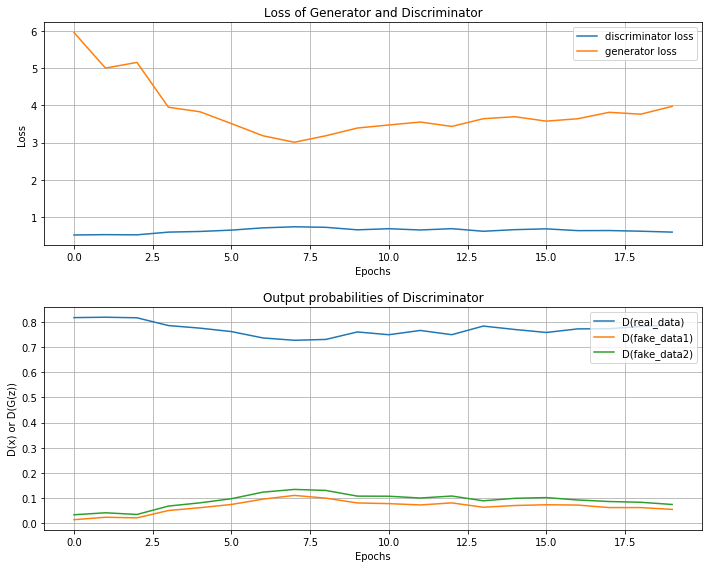

In [67]:
train_history(train_hist, show=True, save=True, path='DCGAN_results/DCGAN_train_hist.png')

# create gif for generator's outputs given a fixed noise as the input
images = []
for epoch in range(NUM_EPOCHS):
    img_name = 'DCGAN_results/Images_fixed/DCGAN_' + str(epoch + 1) + '.png'
    images.append(imageio.imread(img_name))
imageio.mimsave('DCGAN_results/generation_animation.gif', images, fps=5)

**Real sample images**

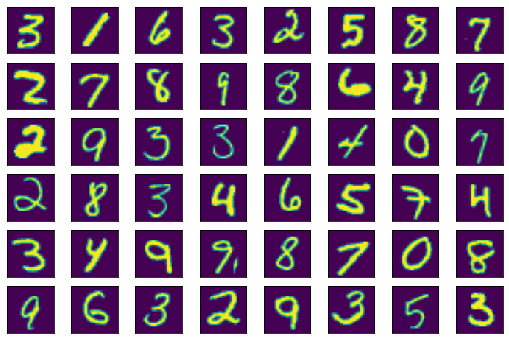

In [110]:
 fig, ax = imshow(samples, 6, 8, (9,6))

**Images generated by the generator**

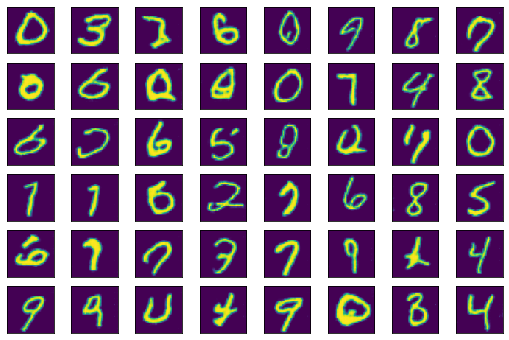

In [108]:
 fig, ax = imshow(G(noise), 6, 8, (9,6))

In [26]:
# this is a hack to display the gif inside the notebook
os.system('cp DCGAN_results/generation_animation.gif DCGAN_results/generation_animation.gif.png')

0

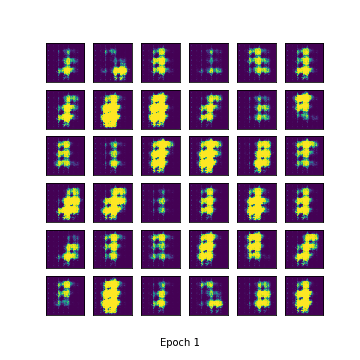

In [27]:
display.Image(filename="DCGAN_results/generation_animation.gif.png")